In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-prediction-x/sample_submission.csv
/kaggle/input/car-price-prediction-x/train.csv
/kaggle/input/car-price-prediction-x/test.csv


In [137]:
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBRegressor
 
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Import Data
Join training data & test data in the all data

In [95]:
train = pd.read_csv('/kaggle/input/car-price-prediction-x/train.csv')
test = pd.read_csv('/kaggle/input/car-price-prediction-x/test.csv')
train['IsTrain'] = 1
test['IsTrain'] = 0
all_data = pd.concat([train, test.drop('Id', axis=1)], axis=0)
all_data.head()

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price,IsTrain
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500.0,1
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500.0,1
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700.0,1
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000.0,1
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000.0,1


# Data Exploration

In [96]:
all_data.describe()

,year,motor_volume,price,IsTrain
count,2053.000000,2053.000000,1642.000000,2053.000000
mean,2014.837311,2.033025,15982.633374,0.799805
std,6.576572,0.248348,7176.084647,0.400244
min,1987.000000,0.200000,462.000000,0.000000
25%,2013.000000,2.000000,12000.000000,1.000000
50%,2017.000000,2.000000,15750.000000,1.000000
75%,2019.000000,2.000000,18500.000000,1.000000
max,2023.000000,4.300000,87000.000000,1.000000


In [97]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2053 entries, 0 to 410
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         2053 non-null   object 
 1   year          2053 non-null   int64  
 2   motor_type    2053 non-null   object 
 3   running       2053 non-null   object 
 4   wheel         2053 non-null   object 
 5   color         2053 non-null   object 
 6   type          2053 non-null   object 
 7   status        2053 non-null   object 
 8   motor_volume  2053 non-null   float64
 9   price         1642 non-null   float64
 10  IsTrain       2053 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 192.5+ KB


## Does the model impact the price?

In [98]:
all_data['model'].unique()

array(['toyota', 'mercedes-benz', 'kia', 'nissan', 'hyundai'],
      dtype=object)

<Axes: xlabel='model', ylabel='price'>

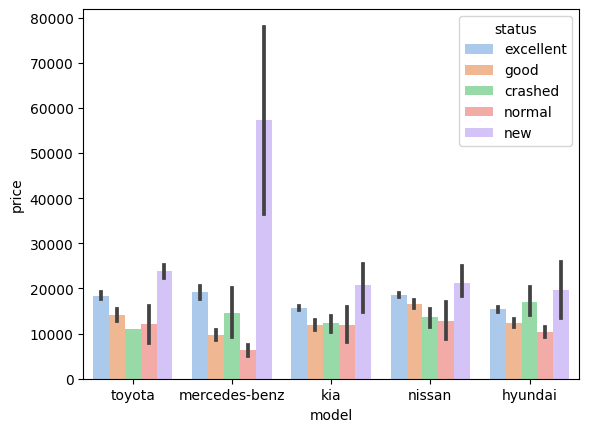

In [99]:
sns.barplot(train,x='model', y='price', hue='status', palette='pastel')

There's some outliers in the data regarding the car models

<Axes: xlabel='model', ylabel='price'>

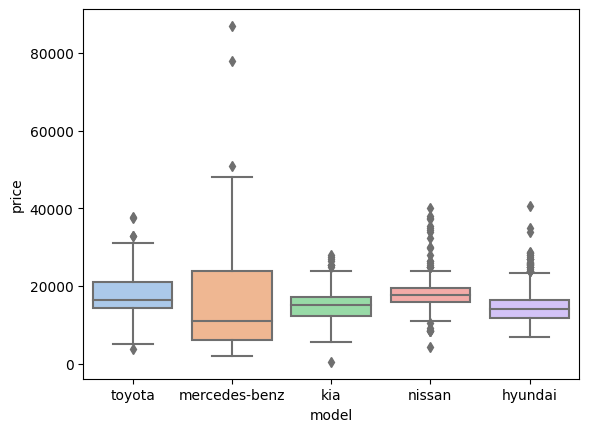

In [100]:
sns.boxplot(train,x='model', y='price', palette='pastel')

## Does the year impact the price?
There's an imbalance regarding the year of car models, which should be in the preprocessing step.

<Axes: xlabel='year', ylabel='price'>

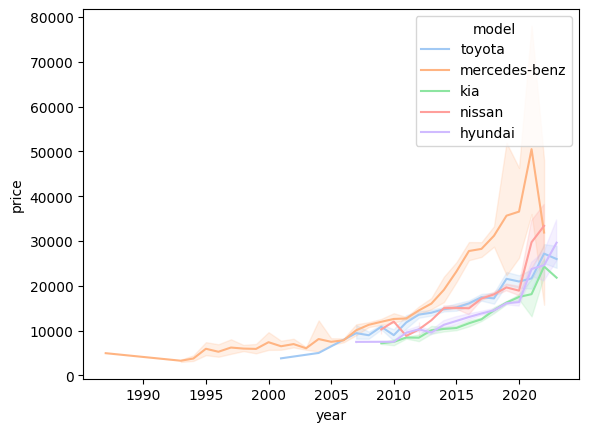

In [101]:
sns.lineplot(train, x='year', y='price', hue='model', palette='pastel')

## Car Type vs Price

<Axes: xlabel='type', ylabel='price'>

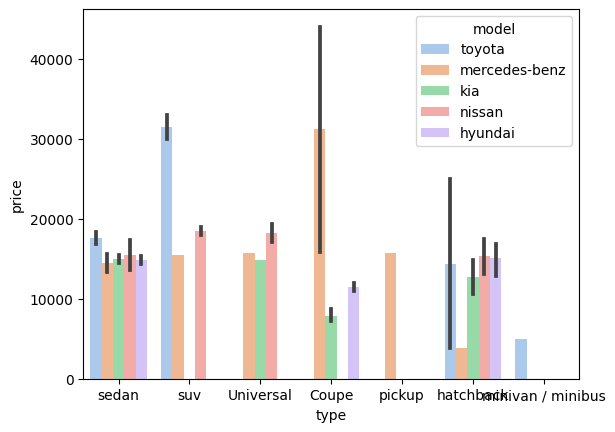

In [102]:
sns.barplot(train, x='type', y='price', hue='model', palette='pastel')

## Color vs Price

<Axes: xlabel='color', ylabel='price'>

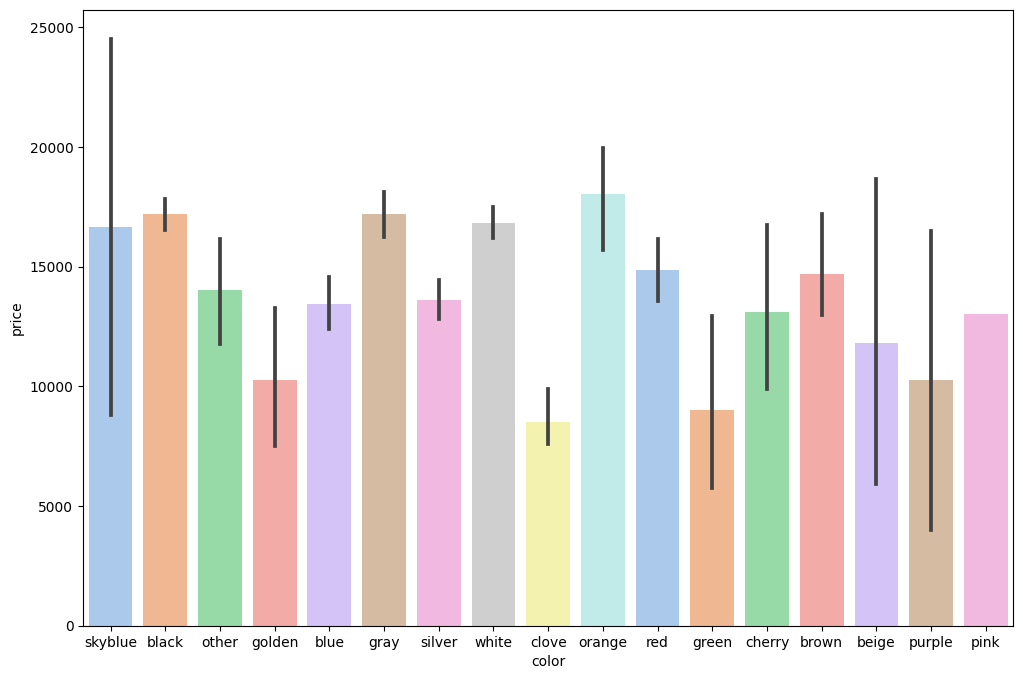

In [103]:
plt.figure(figsize=(12,8))
sns.barplot(train, x='color', y='price', palette='pastel')

## Motor Vol. vs Price

<Axes: xlabel='motor_volume', ylabel='price'>

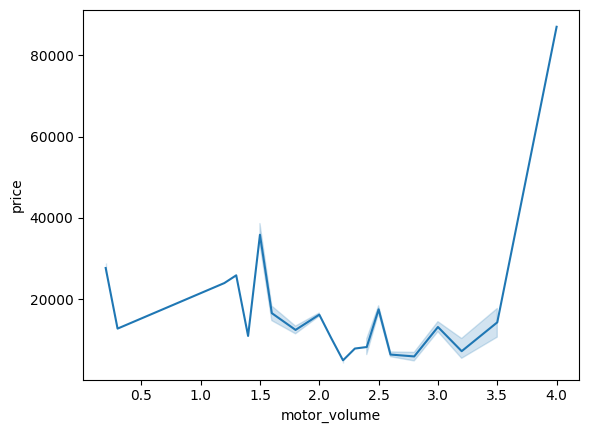

In [104]:
sns.lineplot(train, x='motor_volume', y='price')

Imbalance in wheel

In [105]:
all_data['wheel'].value_counts()

wheel
left     2051
right       2
Name: count, dtype: int64

# Data Preprocessing

- Remove Outliers
- Convert Running to Kilometers
- Convert Year to Age


## Remove Outliers

In [106]:
columns = ['price', 'year']
outlier_percentage = {}

for column in columns:
    column_data = train[column]

    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = column_data[(column_data < lower) | (column_data > upper)]
    outlier_percentage[column] = len(outliers) / len(column_data) * 100

    print(f"Count of outliers in column '{column}': {len(outliers)}")
    print(f"Percentage of outliers in column '{column}':{percentage:.2f}%")
    print()
    print(f"Lower : {lower}")
    print(f"Upper : {upper}")
    print()
    print(f"Data Outlier': {np.array(outliers)}")

Count of outliers in column 'price': 92
Percentage of outliers in column 'price':9.68%

Lower : 2250.0
Upper : 28250.0

Data Outlier': [30000 31000  2100 40000 48000 28700 29000 29000 40700 32000 35000 32500
 30000 29000 51000   462 31700 31000 34000 34000 28300 30000 87000 31500
 36000 33000 28900 33700 78000 33500 28500 32000 30000 37262 40000 29500
 31000 34000 33000 28700 33000 35000 35000 32700 37500 35500 32700 39500
 37500 36500 35500 28500 33000 30000 34900 37500 35000 33500 34500 33000
 29800 40000 35000 28500 37000 42000 37500 28486 29500 30000 39000 33600
 31000 30000 28500 35900 38000 28800 37800 35000 33000 31000 29900 35000
 32900 28500 40000 31000 35000 30000 32800 28500]
Count of outliers in column 'year': 159
Percentage of outliers in column 'year':9.68%

Lower : 2004.0
Upper : 2028.0

Data Outlier': [2002 2001 2002 1997 1998 2001 1999 1995 2001 2000 1996 1996 2001 1999
 2001 1993 2002 1997 1997 1998 2000 2001 1995 1995 2003 1997 1995 1998
 1996 1997 1998 2003 1998 199

In [107]:
def remove_outliers(df):
    column_list = ['price', 'year']

    for col in column_list:
        column_data = df[col]

        # Detect Outliers
        Q1 = np.percentile(column_data, 25)
        Q3 = np.percentile(column_data, 75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Remove Outlier
        df = df[(column_data >= lower) & (column_data <= upper)]

    return df

## Running to km

In [108]:
all_data['running'].apply(lambda x: float(x.split('  ')[0]) * 1.6 if x.split('  ')[1] == 'miles' else float(x.split('  ')[0]))

0        3000.0
1      132000.0
2      152000.0
3      219200.0
4      130000.0
         ...   
406     33400.0
407     96000.0
408    218000.0
409     64000.0
410    192000.0
Name: running, Length: 2053, dtype: float64

In [134]:
def convert_to_km(df):
    df['running_km'] = df['running'].apply(lambda x: float(x.split('  ')[0]) * 1.6 if x.split('  ')[1] == 'miles' else float(x.split('  ')[0]))
    return df.drop('running', axis=1)

## Convert Year to Age

In [110]:
all_data['year'].apply(lambda x: 2025 - x)

0       3
1      11
2       7
3      23
4       8
       ..
406     4
407     8
408    13
409     5
410     8
Name: year, Length: 2053, dtype: int64

In [111]:
def convert_to_age(df):
    df['age'] = df['year'].apply(lambda x: 2025 - x)
    return df.drop('year', axis=1)

# Pipeline

In [128]:
preprocess = all_data.copy()
preprocess.columns

Index(['model', 'year', 'motor_type', 'running', 'wheel', 'color', 'type',
       'status', 'motor_volume', 'price', 'IsTrain'],
      dtype='object')

In [113]:
columns_to_drop = ['wheel', 'price', 'IsTrain']
numerical_columns = ['age', 'running_km', 'motor_volume']
categorical_columns = ['model', 'color', 'type', 'motor_type']
ordinal_columns = ['status']

In [135]:
numerical_transformer = Pipeline(
    steps = [('StandardScaler', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps = [('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output = False))]
)

ordinal_transformer = Pipeline(
    steps = [('OrdinalEncoder', OrdinalEncoder(categories=[['crashed', 'normal', 'good', 'excellent', 'new']]))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('column_dropper', 'drop', columns_to_drop),
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('ordinal', ordinal_transformer, ordinal_columns)
    ]
)

pipeline = Pipeline(
    steps=[
        ('convert_to_km', FunctionTransformer(convert_to_km)),
        ('convert_to_age', FunctionTransformer(convert_to_age)),
        ('preprocessing', preprocessor),
    ]
)

In [136]:
# Remove Outliers
preprocess_train = remove_outliers(preprocess[preprocess['IsTrain'] == 1])
preprocess_test = preprocess[preprocess['IsTrain'] == 0]

X = pipeline.fit_transform(preprocess_train)
y = preprocess_train['price']
X_submission = pipeline.transform(preprocess_test)

<ipython-input-134-7d4747496015>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['running_km'] = df['running'].apply(lambda x: float(x.split('  ')[0]) * 1.6 if x.split('  ')[1] == 'miles' else float(x.split('  ')[0]))
